# LLM Zoomcamp 
## Module 01: Introduction - Homework Assignment

In this homework assignment, we will apply the concepts learned in Module 01 to implement a simple RAG pipeline. The goal is to index FAQ documents from the Zoomcamp courses and create a Q&A system that can answer questions about these documents.

In [6]:
from IPython.display import display, Image
import requests 
from elasticsearch import Elasticsearch
from tqdm.auto import tqdm
import tiktoken

### **Question 1 - Running Elastic**

We ran the docker command to create a Docker container for `elasticsearch`. Here is how our localhost looks like.

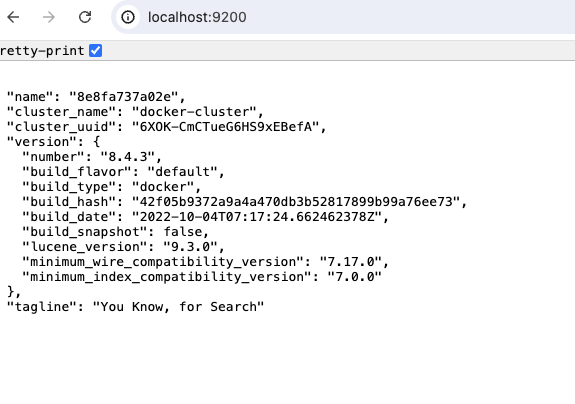

In [7]:
Image('img/hw1_q1.png')

Therefore, the `build_hash` is **42f05b9372a9a4a470db3b52817899b99a76ee73**.

### **Question 2 - Indexing the data**

In [8]:
docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

In [9]:
es_client = Elasticsearch('http://localhost:9200/')
es_client.info()

ObjectApiResponse({'name': '8e8fa737a02e', 'cluster_name': 'docker-cluster', 'cluster_uuid': '6XOK-CmCTueG6HS9xEBefA', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [10]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} 
        }
    }
}

index_name = 'course-questions'

es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [11]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document = doc)

100%|██████████| 948/948 [00:01<00:00, 782.62it/s]


### **Question 3 - Searching**

In [12]:
query = 'How do I execute a command in a running docker container?'

In [13]:
search_query = {
    "size": 5,
    "query": {
        "bool": {
            "must": {
                "multi_match": {
                    "query": query,
                    "fields": ["question^4", "text"],
                    "type": "best_fields"
                }
            }
        }
    }
}

In [14]:
response = es_client.search(index = index_name, body = search_query)

In [15]:
scores = []

for hit in response['hits']['hits']:
    scores.append(hit['_score'])

In [16]:
print(f'The top record score is {round(max(scores),2)}')

The top record score is 83.03


### **Question 4 - Filtering**

In [17]:
search_query = {
    "size": 3,
    "query": {
        "bool": {
            "must": {
                "multi_match": {
                    "query": query,
                    "fields": ["question^4", "text"],
                    "type": "best_fields"
                }
            },
            "filter": {
                "term": {
                    "course": "machine-learning-zoomcamp"
                }
            }
        }
    }
}

response = es_client.search(index = index_name, body = search_query)

In [23]:
questions = []

for hit in response['hits']['hits']:
    questions.append(hit['_source']['question'])



print(f' The top third question is {questions[2]}')

 The top third question is How do I copy files from a different folder into docker container’s working directory?


### **Question 5 - Building a prompt**

In [19]:
answers =  []

for hit in response['hits']['hits']:
    answers.append(hit['_source']['text'])

In [20]:

context_template = """
Q: {question}
A: {text}
""".strip()

# Build the context
full_context = ""
for q, c in zip(questions, answers):
    full_context += context_template.format(question=q, text=c)
    full_context += "\n\n"

full_context = full_context.strip()

prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
{context}
""".strip()

question = "How do I execute a command in a running docker container?"

full_prompt = prompt_template.format(question=question, context=full_context)

prompt_length = len(full_prompt)
print(f"The length of the prompt is: {prompt_length}")

The length of the prompt is: 1462


### **Question 6 - Tokens**

In [21]:
encoding = tiktoken.encoding_for_model("gpt-4o")

In [22]:
print(f'The number of tokens after encoding is {len(encoding.encode(full_prompt))}')

The number of tokens after encoding is 322
